<a href="https://colab.research.google.com/github/lacykaltgr/ait-assessments/blob/main/11_Huggingface_Text_Classification_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assessment: Classifying authors with DistilBERT
Please use the HuggingFace Transformer library for author classification:
* use the DistilBERT architecture this time,
* collect data from 4 authors,
* create, train and evaluate a classifier with DistilBERT and 4 authors.



In [1]:
%%capture
!pip install tensorflow transformers
!python -m spacy download en

In [2]:
import tensorflow as tf
from tensorflow.keras import activations, optimizers, losses
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import pickle
import spacy
from urllib.request import urlretrieve
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

## 1. Exercise: Dataset acquisition

In [3]:
nlp = spacy.load("en_core_web_sm")

def sentencesSplit(raw_text):
  doc = nlp(raw_text)
  sentences = [sent.text for sent in doc.sents]
  return sentences


In [112]:
book1="http://www.gutenberg.org/files/2151/2151-0.txt"
book2="https://www.gutenberg.org/cache/epub/70589/pg70589.txt"
book3="https://www.gutenberg.org/ebooks/64317.txt.utf-8"
book4="https://www.gutenberg.org/files/16/16-0.txt"
urlretrieve(book1, 'book1.txt')
urlretrieve(book2, 'book2.txt')
urlretrieve(book3, 'book3.txt')
urlretrieve(book4, 'book4.txt')
book1_text = open("book1.txt", encoding='utf-8').read().lower()
book2_text = open("book2.txt", encoding='utf-8').read().lower()
book3_text = open("book3.txt", encoding='utf-8').read().lower()
book4_text = open("book4.txt", encoding='utf-8').read().lower()

In [113]:
book1_sents = sentencesSplit(book1_text)
book2_sents = sentencesSplit(book2_text)
book3_sents = sentencesSplit(book3_text)
book4_sents = sentencesSplit(book4_text)

In [127]:
book1_sents

['\ufeffthe project gutenberg ebook of the works of edgar allan poe, volume 5, by edgar allan poe\n\nthis ebook is for the use of anyone anywhere in the united states and\nmost other parts of the world at no cost and with almost no restrictions\nwhatsoever.',
 'you may copy it, give it away or re-use it under the terms\nof the project gutenberg license included with this ebook or online at\nwww.gutenberg.org.',
 'if you are not located in the united states, you\nwill have to check the laws of the country where you are located before\nusing this ebook.\n\n',
 'title: the works of edgar allan poe, volume 5\n\nauthor: edgar allan poe\n\nrelease date: april, 2000',
 '[ebook #2151]\n',
 '[most recently updated: january 25, 2023]\n\nlanguage: english\n\ncharacter set encoding: utf-8\n\nproduced by: david widger\nrevised by richard tonsing.\n\n',
 '*** start of the project gutenberg ebook the works of edgar allan poe, vol.',
 '5 ***\n\n\n\n\nthe works of edgar allan poe\n\nby edgar allan poe\

In [114]:
TRAIN_SIZE = 0.8
t_split_1  = int(TRAIN_SIZE*len(book1_sents))
t_split_2  = int(TRAIN_SIZE*0.8*len(book2_sents))
t_split_3  = int(TRAIN_SIZE*len(book3_sents))
t_split_4  = int(TRAIN_SIZE*len(book4_sents))

In [115]:
print(t_split_1)
print(t_split_2)
print(t_split_3)
print(t_split_4)

2451
2224
2416
2256


In [150]:
from keras.utils import to_categorical

X_train = book1_sents[:t_split_1] \
        + book2_sents[:t_split_2] \
        + book3_sents[:t_split_3] \
        + book3_sents[:t_split_4]
Y_train = np.concatenate((
    np.full(t_split_1, 0),
    np.full(t_split_2, 1),
    np.full(t_split_3, 2),
    np.full(t_split_4, 3)
    #to_categorical(np.full(t_split_1, 0), num_classes=4),
    #to_categorical(np.full(t_split_2, 1), num_classes=4),
    #to_categorical(np.full(t_split_3, 2), num_classes=4), 
    #to_categorical(np.full(t_split_4, 3), num_classes=4)
))

X_test  = book1_sents[t_split_1:]  \
    + book2_sents[t_split_2:]      \
    + book3_sents[t_split_3:]      \
    + book4_sents[t_split_4:]   

Y_test = np.concatenate((
    np.full(len(book1_sents)-t_split_1, 0),
    np.full(len(book2_sents)-t_split_2, 1),
    np.full(len(book3_sents)-t_split_3, 2),
    np.full(len(book4_sents)-t_split_4, 3)
    #to_categorical(np.full(len(book1_sents)-t_split_1, 0), num_classes=4),
    #to_categorical(np.full(len(book2_sents)-t_split_2, 1), num_classes=4),
    #to_categorical(np.full(len(book3_sents)-t_split_3, 2), num_classes=4),
    #to_categorical(np.full(len(book4_sents)-t_split_4, 3), num_classes=4)
))

In [176]:
Y_test[1000:]

array([1, 1, 1, ..., 3, 3, 3])

# 2. Exercise: Data preparation

We are using [DisitlBERT](https://huggingface.co/transformers/model_doc/distilbert.html) model, in which we have to convert each sentence into a tuple containing the text's [input ids](https://huggingface.co/transformers/glossary.html#input-ids) and the corresponding [attention masks](https://huggingface.co/transformers/glossary.html#attention-mask). In order to do so, the corresponding tokizer can be used: [DistilBertTokenizer](https://huggingface.co/transformers/model_doc/distilbert.html#distilberttokenizer)

We trim or pad the processed sentences to MAX_LEN (due to `truncation=True` and `padding=True` parameters) - this is an easy solution to handle inputs with different lengths.

In [151]:
MODEL_NAME = 'distilbert-base-uncased'
MAX_LEN = 20

sample = X_train[100]

tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)
inputs = tokenizer(sample)

print(f'sentence: \'{sample}\'')
print(f'input ids: {inputs["input_ids"]}')
print(f'attention mask: {inputs["attention_mask"]}')

sentence: 'there are, nevertheless, three or
      four female heads, of an ethereal beauty-portraits in the manner of sully.
      '
input ids: [101, 2045, 2024, 1010, 6600, 1010, 2093, 2030, 2176, 2931, 4641, 1010, 1997, 2019, 28855, 15879, 5053, 1011, 9668, 1999, 1996, 5450, 1997, 21396, 2135, 1012, 102]
attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


This transformation must be applied to each sentence in the corpus. Here's how we do it: `construct_encodings` maps the tokenizer to each `sentence` and aggregates them:

In [152]:
def construct_encodings(x, tokenizer, max_len, trucation=True, padding=True):
    return tokenizer(x, max_length=max_len, truncation=trucation, padding=padding)
    
encodings_train = construct_encodings(X_train, tokenizer, max_len=MAX_LEN)
encodings_test = construct_encodings(X_test, tokenizer, max_len=MAX_LEN)

In [153]:
encodings_test

{'input_ids': [[101, 25222, 1012, 1521, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 22320, 13048, 999, 2087, 13048, 999, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2071, 2025, 2228, 2009, 2825, 2061, 2210, 2051, 2071, 2061, 2172, 11477, 2028, 999, 2000, 2360, 1996, 102], [101, 11085, 5292, 999, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 2002, 2003, 8776, 999, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 2107, 2019, 4070, 2002, 2435, 2033, 1997, 2010, 4990, 999, 1521, 2048, 21285, 2031, 2081, 2017, 3280, 2007, 102], [101, 2106, 1045, 2025, 2425, 2017, 1029, 25222, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 2017, 2106, 1011, 1998, 2664, 1521, 22320, 4326, 999, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 2021, 2995, 2004, 4326, 1010, 2129, 2172, 1045, 2001, 13534, 999, 102, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2467, 2245, 1996, 4656, 1037, 24067, 2100, 2158, 1012, 3804, 1012, 102, 0, 0, 0, 0, 0, 0], [101, 2061, 1010, 2061, 1010, 2017, 2156, 999,

Now we have to convert the `encodings` and `y` (which holds the classes of the authors) into a [Tensorflow Dataset object](https://www.tensorflow.org/api_docs/python/tf/data/Dataset):



In [165]:
def construct_tfdataset(encodings, y=None):
    if y is not None:
        return tf.data.Dataset.from_tensor_slices((dict(encodings),y))
    else:
        # this case is used when making predictions on unseen samples after training
        return tf.data.Dataset.from_tensor_slices(dict(encodings))
    
tfdataset_train = construct_tfdataset(encodings_train, Y_train)
tfdataset_test  = construct_tfdataset(encodings_test, Y_test)

Shuffle the training data and create batches.

In [166]:
BATCH_SIZE = 256

tfdataset_train = tfdataset_train.shuffle(len(X_train))
tfdataset_train = tfdataset_train.take(len(X_train))
tfdataset_test = tfdataset_test.take(len(X_test))
tfdataset_train = tfdataset_train.batch(BATCH_SIZE)
tfdataset_test = tfdataset_test.batch(BATCH_SIZE)

Our data is finally ready. Now we can do the fun part: model fitting!

# 3. Exercise: Fine-tuning the model

Fine-tuning the model is as easy as instantiating a model instance, [optimizer](https://developers.google.com/machine-learning/glossary#optimizer), and [loss](https://developers.google.com/machine-learning/glossary#loss), and then compiling/fitting:

In [167]:
N_EPOCHS = 2
N_CLASSES = 4

model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=N_CLASSES)
optimizer = optimizers.Adam()
loss = losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

model.fit(tfdataset_train, epochs=N_EPOCHS)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_299']
You should probably TRAIN this model on a down-stream task to be able to use 

Epoch 1/2
37/37 [==============================] - 43s 453ms/step - loss: 5.3355 - accuracy: 0.2434
Epoch 2/2
37/37 [==============================] - 16s 418ms/step - loss: 1.3863 - accuracy: 0.2392


In [111]:
X_train

['\ufeffthe project gutenberg ebook of the works of edgar allan poe, volume 5, by edgar allan poe\n\nthis ebook is for the use of anyone anywhere in the united states and\nmost other parts of the world at no cost and with almost no restrictions\nwhatsoever.',
 'you may copy it, give it away or re-use it under the terms\nof the project gutenberg license included with this ebook or online at\nwww.gutenberg.org.',
 'if you are not located in the united states, you\nwill have to check the laws of the country where you are located before\nusing this ebook.\n\n',
 'title: the works of edgar allan poe, volume 5\n\nauthor: edgar allan poe\n\nrelease date: april, 2000',
 '[ebook #2151]\n',
 '[most recently updated: january 25, 2023]\n\nlanguage: english\n\ncharacter set encoding: utf-8\n\nproduced by: david widger\nrevised by richard tonsing.\n\n',
 '*** start of the project gutenberg ebook the works of edgar allan poe, vol.',
 '5 ***\n\n\n\n\nthe works of edgar allan poe\n\nby edgar allan poe\

## 4. Exercise: Evaluation

Let's test our model with the test set and the default classification metrics.

In [161]:
print(model.evaluate(tfdataset_test))

24/24 [==============================] - 4s 83ms/step - loss: 1.3863 - accuracy: 0.1991
[1.3862948417663574, 0.19907712936401367]


In [168]:
preds = model.predict(tfdataset_test)
preds_classes = np.argmax(preds.logits, axis=1)

12/12 [==============================] - 3s 157ms/step


In [163]:
preds

TFSequenceClassifierOutput(loss=None, logits=array([[-7.470154  , -5.100324  , -1.0024567 , -3.9013116 ],
       [-7.473153  , -5.0789976 , -0.99795365, -3.9014585 ],
       [-7.472142  , -5.092488  , -1.0002866 , -3.9014883 ],
       ...,
       [-7.470933  , -5.0905604 , -1.000764  , -3.9007277 ],
       [-7.4691916 , -5.1024804 , -1.0028589 , -3.9012387 ],
       [-7.475416  , -5.073321  , -0.9967153 , -3.901283  ]],
      dtype=float32), hidden_states=None, attentions=None)

In [169]:
y_test = tfdataset_test.map(lambda x, y: y).unbatch()
y_test = np.array(list(y_test.as_numpy_iterator()))

In [172]:
print(classification_report(preds_classes, y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       1.00      0.19      0.31      3034

    accuracy                           0.19      3034
   macro avg       0.25      0.05      0.08      3034
weighted avg       1.00      0.19      0.31      3034



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

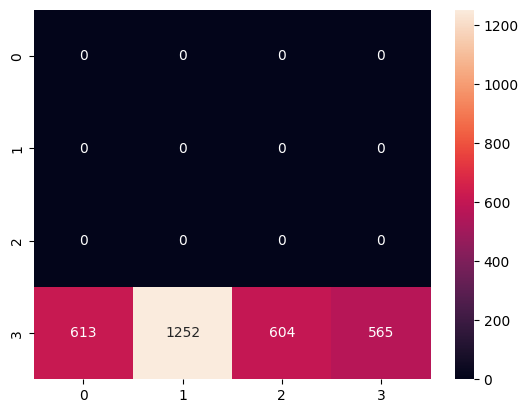

In [173]:
conf=confusion_matrix(preds_classes,y_test)
sns.heatmap(conf, annot=True, fmt='d')